In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from limitedmnist import LimitedMNIST

In [3]:
batch_size = 32

labels = [0, 1, 2]
n = len(labels)

# Load in data
def onehot(label):
    y = torch.LongTensor(n)
    y.zero_()
    y[label] = 1
    return y

def bernoulli(x):
    return torch.bernoulli(x)

mnist = LimitedMNIST('./', train=True, transform=bernoulli, target_transform=onehot, digits=labels)
mnist_val = LimitedMNIST('./', train=False, target_transform=onehot, digits=labels)

# Unlabelled data
unlabelled = torch.utils.data.DataLoader(mnist, batch_size=100, shuffle=True, num_workers=2)

# Labelled data
labelled = next(iter(unlabelled))

# Validation data
validation = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=True, num_workers=2)

In [4]:
from dgm import DeepGenerativeModel, LabelledLoss, train_dgm, generate_label

n_labels_per_class = 10
ratio = len(mnist)/n_labels_per_class
model = DeepGenerativeModel(ratio, [28 * 28, n, 16, 128])
#model.cuda()

objective = LabelledLoss(n_labels=n)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
for epoch in range(100):
    # Perform single train step
    L, U = train_dgm(model, unlabelled, labelled, optimizer, objective, cuda=False)

    # Check validation accuracy
    accuracy = []
    for x, y in validation:
        _, prediction = torch.max(model.classifier(Variable(x)), 1)
        _, y = torch.max(y, 1)

        accuracy += [torch.mean((prediction.data == y).float())]
    print("Epoch: {0:} labelled loss: {1:.3f}, unlabelled loss: {2:.3f}, accuracy: {3:3.2f}".format(epoch,
                                                                                    L.data[0], U.data[0],
                                                                                    np.mean(accuracy)))

Epoch: 0 labelled loss: 691.976, unlabelled loss: 556.790, accuracy: 0.54
Epoch: 1 labelled loss: 682.949, unlabelled loss: 552.813, accuracy: 0.72
Epoch: 2 labelled loss: 676.915, unlabelled loss: 549.648, accuracy: 0.82
Epoch: 3 labelled loss: 667.461, unlabelled loss: 544.842, accuracy: 0.87
Epoch: 4 labelled loss: 660.713, unlabelled loss: 542.137, accuracy: 0.89
Epoch: 5 labelled loss: 653.156, unlabelled loss: 537.948, accuracy: 0.89
Epoch: 6 labelled loss: 645.745, unlabelled loss: 534.332, accuracy: 0.89
Epoch: 7 labelled loss: 638.943, unlabelled loss: 530.893, accuracy: 0.89
Epoch: 8 labelled loss: 631.629, unlabelled loss: 528.403, accuracy: 0.88
Epoch: 9 labelled loss: 623.614, unlabelled loss: 524.282, accuracy: 0.88
Epoch: 10 labelled loss: 616.340, unlabelled loss: 520.167, accuracy: 0.88
Epoch: 11 labelled loss: 610.563, unlabelled loss: 516.591, accuracy: 0.88
Epoch: 12 labelled loss: 603.627, unlabelled loss: 512.321, accuracy: 0.89
Epoch: 13 labelled loss: 595.826, u

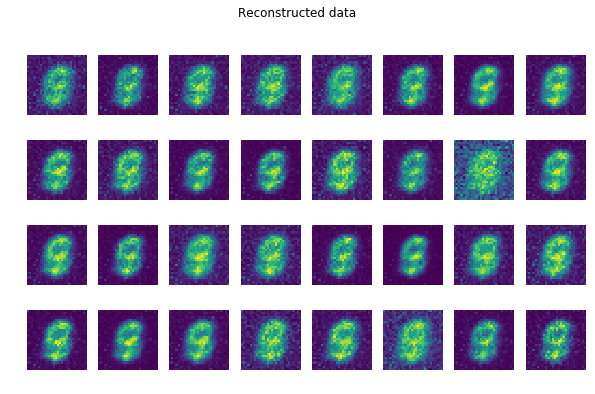

In [7]:
f, axarr = plt.subplots(4, 8, figsize=(10, 6))

input = Variable(labelled[0][:50])
label = Variable(labelled[1][:50].type(torch.FloatTensor))
x, *_ = model(input, label)

plt.suptitle("Reconstructed data")

for i in range(batch_size):
    ims = x.data.numpy().reshape(-1, 28, 28)
    axarr[i//8, i%8].imshow(ims[i])
    axarr[i//8, i%8].axis("off")

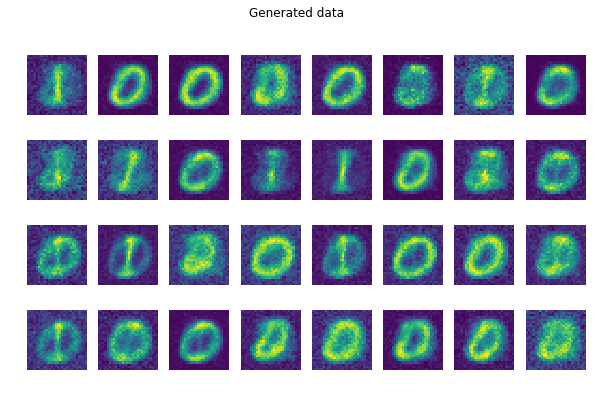

In [19]:
f, axarr = plt.subplots(4, 8, figsize=(10, 6))

z = torch.randn(batch_size, 16)
label = generate_label(batch_size, 0, 3)

input = (Variable(z), Variable(label))
generated = model.generate(*input)

plt.suptitle("Generated data")

for i in range(batch_size):
    ims = generated.data.numpy().reshape(-1, 28, 28)
    axarr[i//8, i%8].imshow(ims[i])
    axarr[i//8, i%8].axis("off")